# Variant C/D Mobile Views – Regression models

The approach for fitting regression models to predict whether users are likely to have viewed the full module on mobile is same as we've used in the previous analyses. Because the outcome is binary, either a user did something or they did not, we use a logistic regression model. We add predictors iteratively until we find the most likely model. Because these events all took place on the mobile site, we do not have a variable for platform. Instead, we'll investigate variant as a variable, and the effect of time.

In [1]:
# https://stackoverflow.com/a/35018739/1091835
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
## libraries
library(tidyverse)
library(data.table)
library(ggplot2)

library(lme4)

library(caret)

library(interactions)
library(multcomp)
library(emmeans)

require(gridExtra)

## library(ROCR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: mvtnorm

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package

## Configuration variables

In [3]:
## Set BLAS threads to 4 so glmer doesn't use all cores
library(RhpcBLASctl)
blas_set_num_threads(4)

## parallelization
options(mc.cores = 4)

### Helper functions

In [4]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC = function(mod, val_data, col_name, plot_title, cutoff_steps = 0.1) {
  preds = predict(mod, val_data, type = "response")
  ROCR_pred = prediction(preds, val_data[[col_name]])
  ROCR_perf = performance(ROCR_pred, "tpr", "fpr")
  plot(ROCR_perf, colorize = TRUE, print.cutoffs.at = seq(0, 1, by = cutoff_steps),
       text.adj = c(-0.2, 1.7), main = plot_title)
}

## Function to output a confusion matrix
confusion_matrix = function(model_predictions, threshold, reference, levels = c("yes", "no")) {
  pred = factor(ifelse(model_predictions >= threshold, levels[1], levels[2]), levels = levels)
  truth = factor(ifelse(reference, levels[1], levels[2]), levels = levels)
  confusionMatrix(pred, truth, mode = 'prec_recall')
}


### Data import and setup

In [6]:
mobile_impression_counts = fread('datasets/variant-test-2-mobile-impression-counts.tsv',
                                 colClasses = c(wiki_db = 'factor', user_registration = 'character'))

In this analysis, we're only interested in users in the Homepage group, with a valid variant assigned, who visited the Homepage. Here's how many of them we have:

In [7]:
length(mobile_impression_counts[hp_enabled == 1 & hp_variant %in% c('C', 'D') & visited_homepage == 1]$wiki)

[1] 13891

Note that the dataset does not include known test accounts, users who were in the control group (meaning they didn't have the Homepage enabled upon registration), or users who turned the Homepage on/off during the experiment. Lastly, we've excluded all users who did not visit the Homepage on mobile in the data gathering.

## Open questions

We might want to change the value of `start_ts`, because the variant test actually started earlier. We chose the Oct 28 date because of the edit tag bug. If we instead measure time passing since the start of the variant test, then a different timestamp needs to be used. I've decided to not do anything about this because we didn't find any meaningful effect of time in the analysis of this experiment, nor in the previous variant test. This is probably because both were of fairly short duration, the current experiment only uses four weeks of data. If we run a longer experiment, or are concerned about time-based effects, this might change.

In [10]:
## Configuration variables for this experiment.
start_ts = as.POSIXct('2020-10-28 18:40:02', tz = 'UTC')
end_ts = as.POSIXct('2020-11-25 18:40:02', tz = 'UTC')

## Convert user_registration into a timestamp
mobile_impression_counts[, user_reg_ts := as.POSIXct(user_registration, format = '%Y%m%d%H%M%S', tz = 'UTC')]

## Calculate time since start of experiment in weeks
mobile_impression_counts[, exp_days := 0]
mobile_impression_counts[, exp_days := difftime(user_reg_ts, start_ts, units = "days")]
mobile_impression_counts[, ln_exp_days := log(1 + as.numeric(exp_days))]
mobile_impression_counts[, ln_exp_weeks := log(1 + as.numeric(exp_days)/7)]

## Binary variable for whether the user clicked to see the full module
mobile_impression_counts[, did_visit_module := 0]
mobile_impression_counts[num_mobile_overlays > 0, did_visit_module := 1]

## Convert all NAs to 0, from
## https://stackoverflow.com/questions/7235657/fastest-way-to-replace-nas-in-a-large-data-table
na_to_zero = function(DT) {
  # or by number (slightly faster than by name) :
  for (j in seq_len(ncol(DT)))
    set(DT,which(is.na(DT[[j]])),j,0)
}

na_to_zero(mobile_impression_counts)

## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

## Remove all control group users, users with an incorrect variant assignment,
## and users that didn't visit the Homepage.
exp_users = mobile_impression_counts[hp_enabled == 1 & hp_variant %in% c('C', 'D') & visited_homepage == 1]

## Split the experiment users into training, testing, and validation datasets
trainIndex <- createDataPartition(exp_users$hp_variant,
                                  p = .8, 
                                  list = FALSE, 
                                  times = 1)
exp_users_train = exp_users[trainIndex,]
exp_users_second = exp_users[-trainIndex,]

testIndex = createDataPartition(exp_users_second$hp_variant, p = .5, list = FALSE, times = 1)

exp_users_test = exp_users_second[testIndex,]
exp_users_validate = exp_users_second[-testIndex,]


# Module Interactions

We'll model this in the same way as we've done for task interactions and task clicks.

## Variant C/D as a predictor

In this first model, we predict whether the user edited based on the variant the user was in, while allowing the overall probability of editing to vary by wiki.

In [11]:
## 1: only variant as a predictor:
mobile.imp.model.1 = glmer(formula = did_visit_module ~ hp_variant + (1 | wiki_db),
                           family = binomial(link = "logit"), data = exp_users_train)

In [12]:
summary(mobile.imp.model.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_visit_module ~ hp_variant + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 12758.7  12780.6  -6376.3  12752.7    11111 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8381 -0.6404 -0.5451  1.2468  2.3367 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.05827  0.2414  
Number of obs: 11114, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.78087    0.07430  -10.51   <2e-16 ***
hp_variantD -0.48402    0.04343  -11.14   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.261

This model suggests that overall, variant D is associated with a lower probability of a user interacting with the Newcomer Task module.

Let us see if there's variation by wiki on this.

In [13]:
## 1: variant as a group-level predictor
mobile.imp.model.1.2 = glmer(formula = did_visit_module ~ hp_variant + (1 + hp_variant | wiki_db),
                             family = binomial(link = "logit"), data = exp_users_train)

In [14]:
summary(mobile.imp.model.1.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_visit_module ~ hp_variant + (1 + hp_variant | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 12762.3  12798.9  -6376.1  12752.3    11109 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8341 -0.6426 -0.5480  1.2402  2.3534 

Random effects:
 Groups  Name        Variance Std.Dev. Corr
 wiki_db (Intercept) 0.05649  0.23768      
         hp_variantD 0.00439  0.06626  0.08
Number of obs: 11114, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.77847    0.07375 -10.555   <2e-16 ***
hp_variantD -0.49015    0.05072  -9.663   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.238

In [16]:
ranef(mobile.imp.model.1.2)

$wiki_db
        (Intercept)   hp_variantD
arwiki  0.053909507  0.0654253990
cswiki -0.003552026 -0.0082612951
fawiki  0.191663268  0.0200154473
frwiki -0.092256145 -0.0416763988
hewiki  0.118486826  0.0175489525
huwiki -0.090224640 -0.0104939614
hywiki -0.105963357 -0.0006309234
kowiki -0.130462343  0.0078702331
plwiki -0.176877088 -0.0159695357
ptwiki -0.424594727 -0.0184744790
ruwiki  0.347996990 -0.0197201911
srwiki -0.029714563 -0.0100146882
svwiki -0.022931218 -0.0013595128
trwiki  0.112870318  0.0036739749
ukwiki -0.128002978 -0.0152754227
viwiki  0.415684694  0.0307319032

with conditional variances for “wiki_db” 

The model is not singular, which suggests that there's enough variation and data to support it. However, the BIC is much worse than the first model. So while there *is* some variation between wikis, it's not clear that it's large enough to be meaningful. We can also see this reflected in that the variation between wikis is small relative to the huge effect of Variant D itself.


## Time as a predictor

We add time as a predictor, in this case a variable measuring the number of weeks between when the user registered and the start of the experiment. This enables us to understand if the probability of a user editing changes as time progresses.

In [17]:
## 5: add time
mobile.imp.model.2 = glmer(formula = did_visit_module ~ hp_variant +
                         ln_exp_weeks + (1 | wiki_db),
                           family = binomial(link = "logit"), data = exp_users_train)


In [18]:
summary(mobile.imp.model.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_visit_module ~ hp_variant + ln_exp_weeks + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 12757.1  12786.4  -6374.6  12749.1    11110 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8742 -0.6351 -0.5436  1.2649  2.4017 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.05765  0.2401  
Number of obs: 11114, groups:  wiki_db, 16

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.68503    0.08965  -7.641 2.15e-14 ***
hp_variantD  -0.48493    0.04344 -11.162  < 2e-16 ***
ln_exp_weeks -0.09354    0.04952  -1.889   0.0589 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hp_vrD
hp_variantD -0.224       
ln_exp_weks -0.564  0.013

In [21]:
## 5.1: time in days
mobile.imp.model.2.1 = glmer(formula = did_visit_module ~ hp_variant +
                             ln_exp_days + (1 | wiki_db),
                             family = binomial(link = "logit"), data = exp_users_train)


In [22]:
summary(mobile.imp.model.2.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_visit_module ~ hp_variant + ln_exp_days + (1 | wiki_db)
   Data: exp_users_train

     AIC      BIC   logLik deviance df.resid 
 12757.5  12786.8  -6374.8  12749.5    11110 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8840 -0.6341 -0.5441  1.2623  2.3887 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.05773  0.2403  
Number of obs: 11114, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.65358    0.10287  -6.354  2.1e-10 ***
hp_variantD -0.48480    0.04344 -11.160  < 2e-16 ***
ln_exp_days -0.05070    0.02850  -1.779   0.0752 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hp_vrD
hp_variantD -0.197       
ln_exp_days -0.694  0.012

Time is marginally significant, but the BIC is much worse. Maybe there is some variation in visits over time, but further investigation is needed to determine if it's meaningful.

## Model across the entire dataset

Our previous models were trained on a random 80% of our dataset. We switch to the full dataset and model again to get a sense of the predictors across all available data.

In [23]:
## 7: full model
mobile.imp.model.full = glmer(formula = did_visit_module ~ hp_variant + (1 | wiki_db),
                              family = binomial(link = "logit"), data = exp_users)

In [24]:
summary(mobile.imp.model.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: did_visit_module ~ hp_variant + (1 | wiki_db)
   Data: exp_users

     AIC      BIC   logLik deviance df.resid 
 15831.1  15853.7  -7912.6  15825.1    13888 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.8158 -0.6380 -0.5354  1.2259  2.3884 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.06606  0.257   
Number of obs: 13891, groups:  wiki_db, 16

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.81460    0.07586  -10.74   <2e-16 ***
hp_variantD -0.49170    0.03905  -12.59   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
hp_variantD -0.228

Estimating the effects using the "divide by 4 rule".

In [26]:
fixef(mobile.imp.model.full)[2] / 4

hp_variantD 
 -0.1229243

The model across the full dataset shows the same trends as we saw with this model on the smaller dataset. We find that Variant D is associated with lower probability of visiting the full module, with a difference of up to -12.3pp.

## Overview table

Across all wikis, what's the difference?

In [34]:
visit_counts = exp_users[, list(n_visitors = sum(.N)),
                       by = c('wiki_db', 'hp_variant')]
mobil_impression_counts = exp_users[did_visit_module == 1, list(n_visited_module = sum(.N)),
                                    by = c('wiki_db', 'hp_variant')]
merged_mobile_impression_counts = merge(visit_counts, mobil_impression_counts,
                                        by = c('wiki_db', 'hp_variant'))
merged_mobile_impression_counts[, percent_visited := 100 * n_visited_module / n_visitors]

In [36]:
merged_mobile_impression_counts$hp_variant = factor(merged_mobile_impression_counts$hp_variant)

In [38]:
plots = lapply(unique(merged_mobile_impression_counts$wiki_db), function(w) {
    ggplot(merged_mobile_impression_counts[wiki_db == w], aes(x = hp_variant, y = percent_visited)) +
        theme_bw() +
        theme(axis.title.x = element_text(size = rel(1.5)),
            axis.text.x = element_text(size = rel(1.25)),
            axis.title.y = element_text(size = rel(1.5)),
            axis.text.y = element_text(size = rel(1.25))) +
        labs(x = "Variant", y = "Probability (in %)", title = w) +
        geom_col(position = "dodge2")
})

# ggsave(plot = g, file = "graphs/tagged_edit_probabilities.png",
#       width = 14, height = 7, units = "in", dpi = "retina")

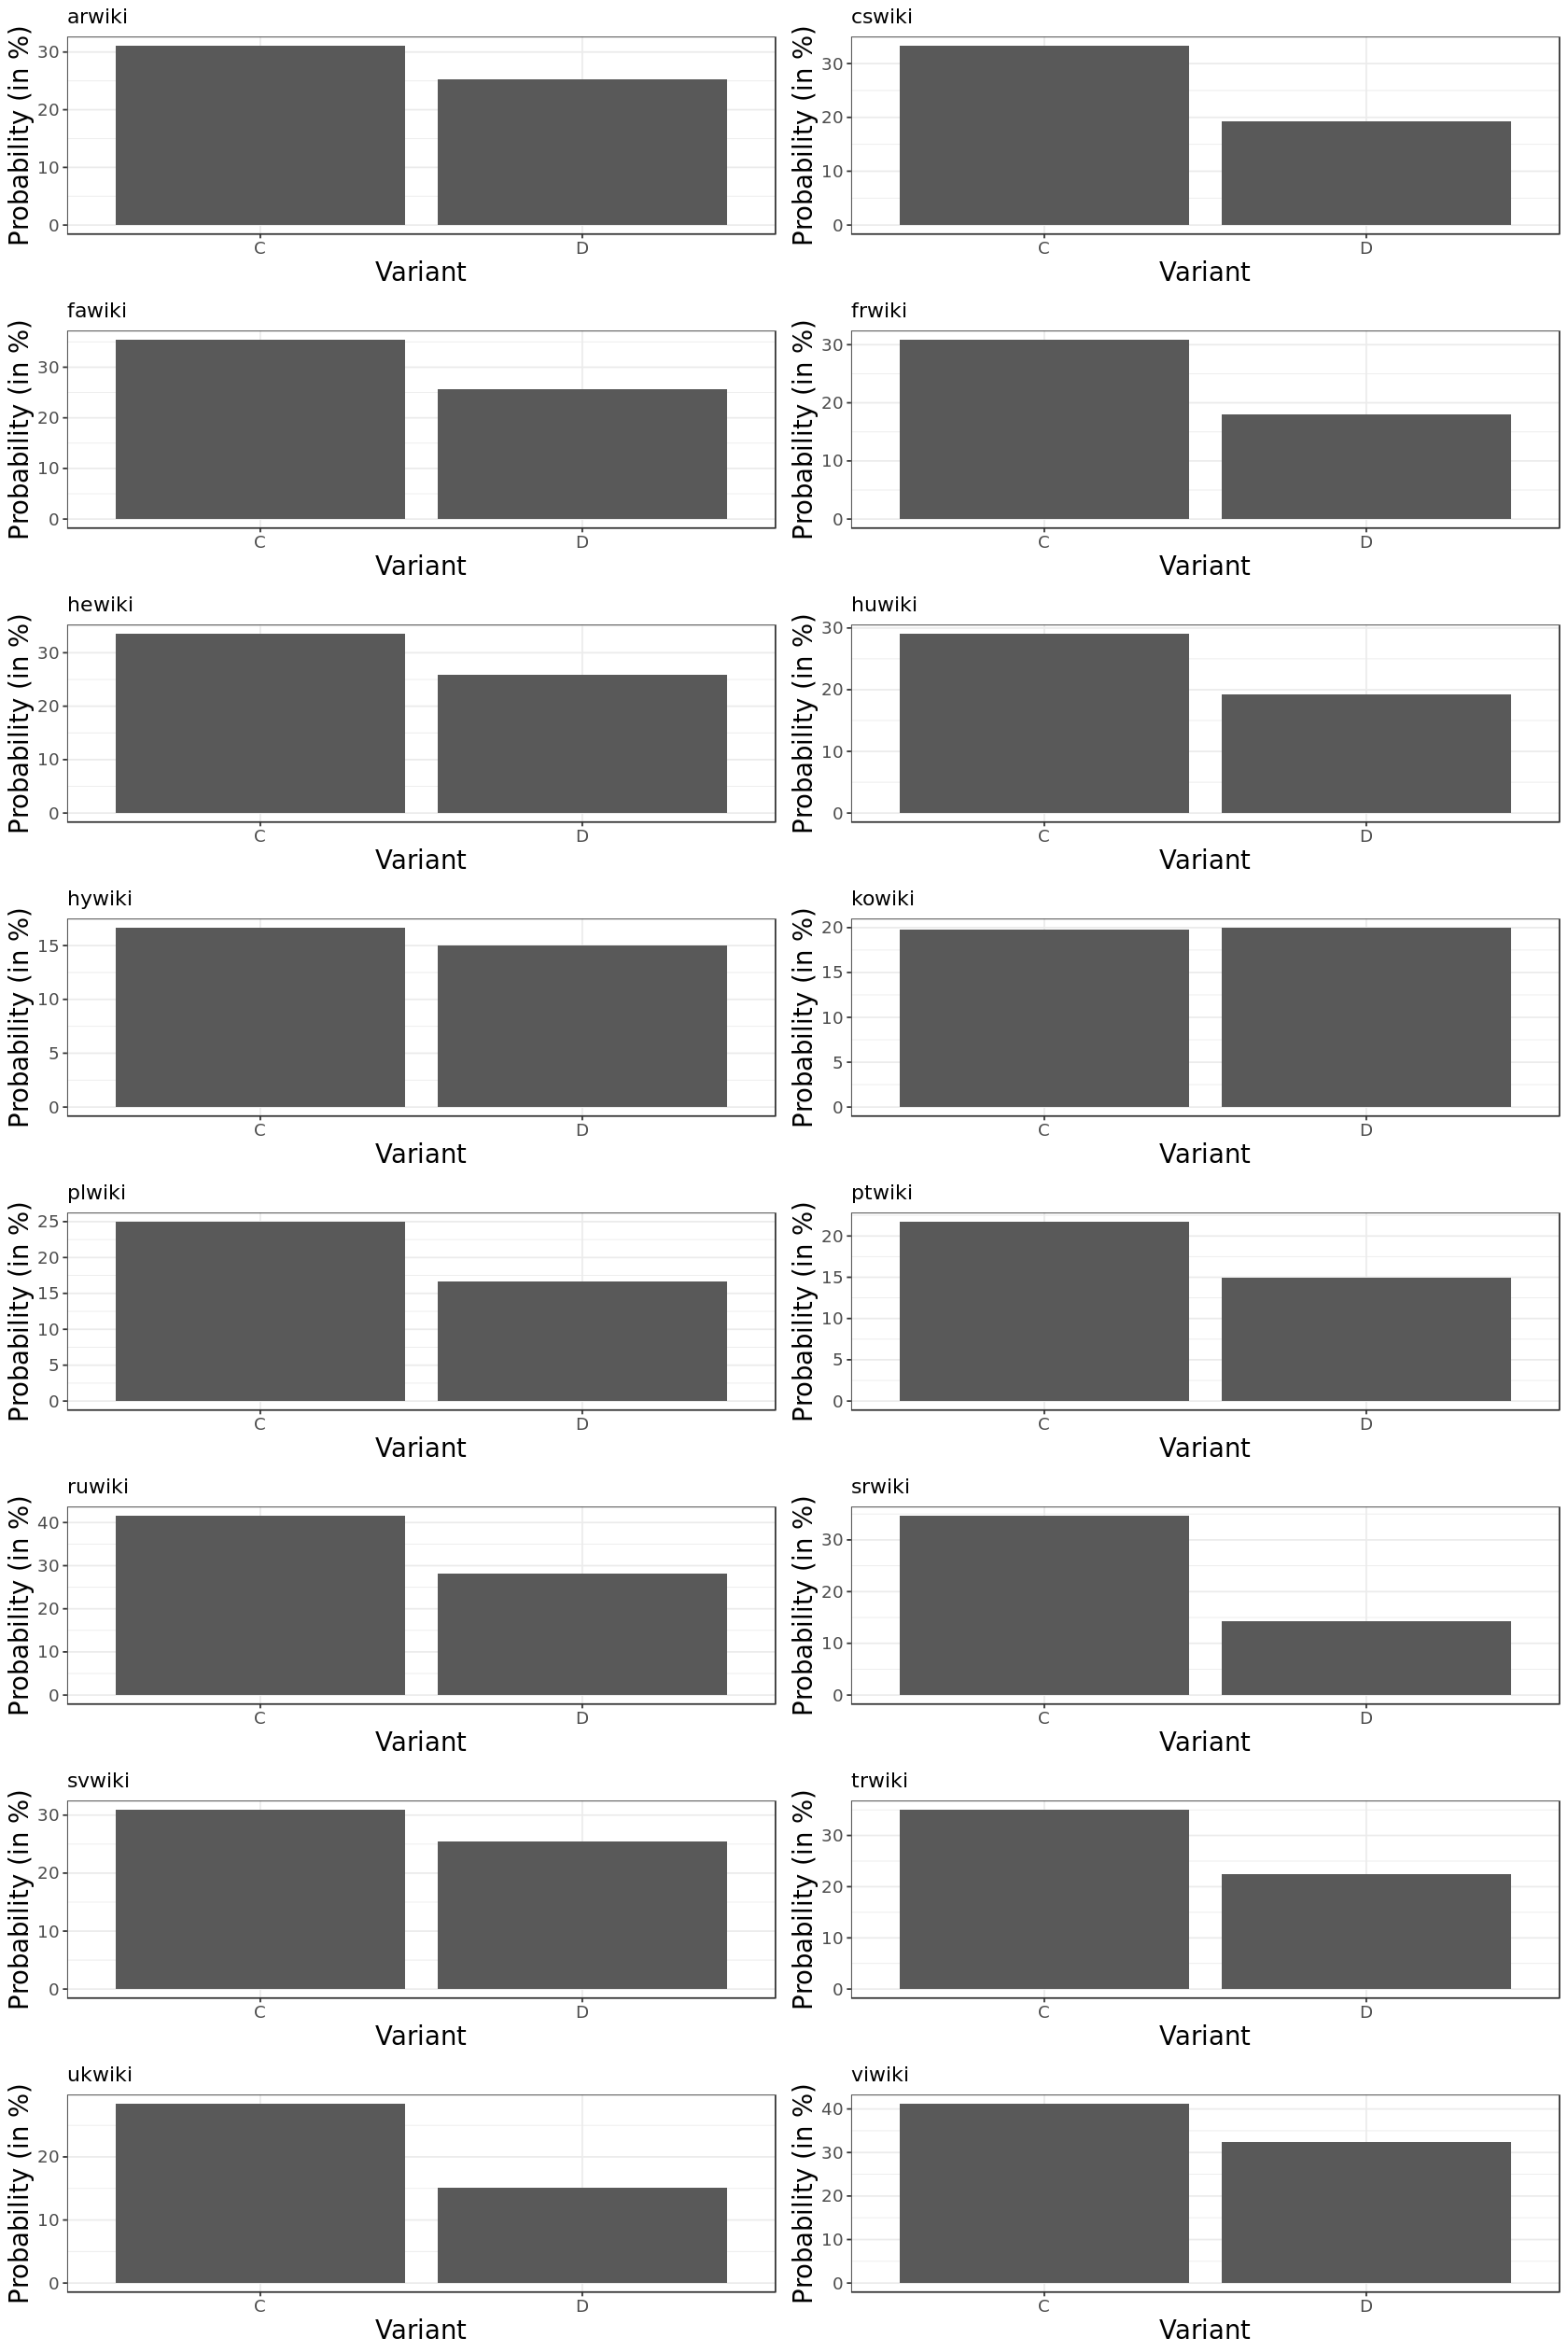

In [39]:
options(repr.plot.width = 14, repr.plot.height = 21)
grid.arrange(grobs = plots, ncol = 2)

## Summary


## Additional analysis

What's the probability difference of visiting the full module on mobile, across the whole dataset?

In [41]:
merged_mobile_impression_counts[, list(n_visitors = sum(n_visitors), n_visited_module = sum(n_visited_module),
                      perc_visited = 100 * sum(n_visited_module) / sum(n_visitors)),
                          by = 'hp_variant']

hp_variant,n_visitors,n_visited_module,perc_visited
<fct>,<int>,<int>,<dbl>
C,6907,2179,31.54771
D,6984,1547,22.15063
